<h1>DATA PREPROCESSING</h1>

<h2>EDA</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt

In [2]:
final_dataset=pd.read_csv('final_dataset2.csv')

In [3]:
import nltk
import re
from nltk.corpus import stopwords

sw_list=stopwords.words('english')
word_count={
    "positive":[],
    "negative":[],
    "neutral":[],
    "irrelevant":[]
}

pattern=re.compile("[^\w ]")

for text,target in zip(final_dataset.text,final_dataset.sentiment):
    text=re.sub(pattern,"",text).lower().split()
    text=[word for word in text if word not in sw_list]
    word_count[target].extend(text)

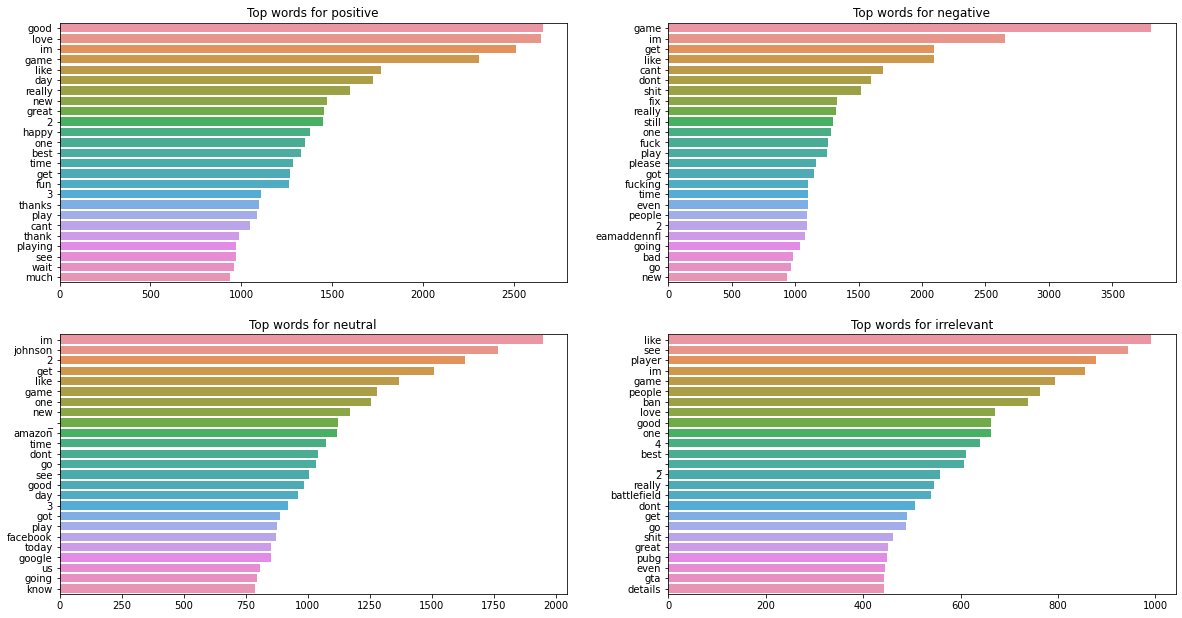

In [4]:
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_count.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

<h2>PREPROCESSING</h2>

In [5]:
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en import English
import emoji
import spacy
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.exceptions import NotFittedError

import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ganes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
class Preprocessor:
    def __init__(self, stopwords=stopwords):
        self.vectorizer = TfidfVectorizer(lowercase=False, max_features=8000,
                                         min_df=10, ngram_range=(1, 3),
                                         tokenizer=None)
        self.stopwords = stopwords
        self.vectorizer_fitted = False
        
    def remove_urls(self, texts):
        print('Removing URLs...')
        pattern = re.compile('(\w+\.com ?/ ?.+)|(http\S+)')
        return [re.sub(pattern, '', text) for text in texts]
    
    def remove_double_space(self, texts):
        print('Removing double space...')
        pattern = re.compile(' +')
        return [re.sub(pattern, ' ', text) for text in texts]
        
    def remove_punctuation(self, texts):
        print('Removing Punctuation...')
        pattern = re.compile('[^a-z ]')
        return [re.sub(pattern, ' ', text) for text in texts]
    
    def remove_stopwords(self, texts):
        print('Removing stopwords...')
        return [[w for w in text.split(' ') if w not in self.stopwords] for text in tqdm(texts)]
    
    def remove_numbers(self, texts):
        print('Removing numbers...')
        return [' '.join([w for w in text if not w.isdigit()]) for text in tqdm(texts)]
    
    def decode_emojis(self, texts):
        print('Decoding emojis...')
        return [emoji.demojize(text, language='en') for text in texts] 
    
    def lemmatize(self, texts):
        print('Lemmatizing...')
        lemmatized_texts = []
        for text in tqdm(texts):
            doc = nlp(text)
            lemmatized_texts.append(' '.join([token.lemma_ for token in doc]))
                                    
        return lemmatized_texts
        
    def transform(self, X, y=None, mode='train'):
        X = X.copy()
        print('Removing Nans...')
        X = X[~X.isnull()]                          # delete nans
        X = X[~X.duplicated()]                      # delete duplicates
        
        if mode == 'train':
            self.train_idx = X.index
        else:
            self.test_idx = X.index
        print('Counting capitalized...')
        capitalized = [np.sum([t.isupper() for t in text.split()]) 
                           for text in np.array(X.values)]  # count capitalized
        # X['cap'] = capitalized
        print('Lowering...')
        X = [text.lower() for text in X]             # lower
        X = self.remove_urls(X)                      # remove urls
        X = self.remove_punctuation(X)               # remove punctuation
        X = self.remove_double_space(X)              # remove double space
        X = self.decode_emojis(X)                    # decode emojis
        X = self.remove_stopwords(X)                 # remove stopwords
        X = self.remove_numbers(X)                   # remove numbers                      
        X = self.lemmatize(X)                        # lemmatize
        
        if not self.vectorizer_fitted:
            self.vectorizer_fitted = True
            print('Fitting vectorizer...')
            self.vectorizer.fit(X)

        print('Vectorizing...')
        X = self.vectorizer.transform(X)             # vectorize
        
        return X

In [7]:
pr=Preprocessor()

In [8]:
data_train=final_dataset
y_final=final_dataset.sentiment

In [9]:
data_train.text.info()

<class 'pandas.core.series.Series'>
RangeIndex: 101475 entries, 0 to 101474
Series name: text
Non-Null Count   Dtype 
--------------   ----- 
101475 non-null  object
dtypes: object(1)
memory usage: 792.9+ KB


In [10]:
y_final.info()

<class 'pandas.core.series.Series'>
RangeIndex: 101475 entries, 0 to 101474
Series name: sentiment
Non-Null Count   Dtype 
--------------   ----- 
101475 non-null  object
dtypes: object(1)
memory usage: 792.9+ KB


In [11]:
data_train_pr = pr.transform(data_train['text'])
data_train_pr = pd.DataFrame.sparse.from_spmatrix(data_train_pr, columns=pr.vectorizer.get_feature_names_out())
y_final = y_final[y_final.index.isin(pr.train_idx)]
y_final.index = data_train_pr.index

Removing Nans...
Counting capitalized...
Lowering...
Removing URLs...
Removing Punctuation...
Removing double space...
Decoding emojis...
Removing stopwords...


100%|██████████| 96965/96965 [00:00<00:00, 129825.70it/s]


Removing numbers...


100%|██████████| 96965/96965 [00:00<00:00, 586857.82it/s]


Lemmatizing...


100%|██████████| 96965/96965 [09:16<00:00, 174.24it/s]


Fitting vectorizer...
Vectorizing...


<h1>Training</h1>

In [12]:
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data_train_pr,y_final,test_size=0.4,random_state=0)

In [14]:
def train_cv(model, X_train, y_train, params, n_splits=5, scoring='f1_weighted'):
    kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)

    cv = RandomizedSearchCV(model,
                        params,
                        cv=kf,
                        scoring=scoring,
                        return_train_score=True,
                        n_jobs=-1,
                        verbose=2,
                        random_state=1
                        )
    cv.fit(X_train, y_train)

    print('Best params', cv.best_params_)
    return cv

In [21]:
rs_parameters = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'C': uniform(scale=10),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'l1_ratio': uniform(scale=10)
    }

In [22]:
X_train.shape

(58179, 8000)

In [23]:
lr = LogisticRegression()
model_cv_lr = train_cv(lr, X_train, y_train, rs_parameters)

bestimator_lr = model_cv_lr.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ganes\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\ganes\AppData\Local\Programs\Pyth

Best params {'C': 8.763891522960384, 'l1_ratio': 8.946066635038473, 'penalty': 'l2', 'solver': 'newton-cg'}


In [24]:
print(classification_report(y_test, bestimator_lr.predict(X_test)))

              precision    recall  f1-score   support

  irrelevant       0.66      0.56      0.61      4815
    negative       0.72      0.74      0.73     11560
     neutral       0.62      0.65      0.64     11271
    positive       0.70      0.70      0.70     11140

    accuracy                           0.68     38786
   macro avg       0.68      0.66      0.67     38786
weighted avg       0.68      0.68      0.68     38786



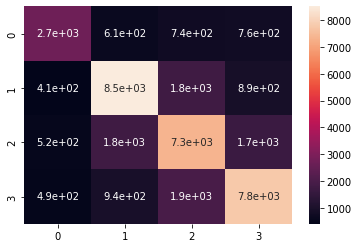

In [25]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, bestimator_lr.predict(X_test)), annot=True)
plt.show()